In [2]:
import numpy as np
import scipy as sc
import scipy.integrate
import matplotlib.pyplot as plt
import warnings
import tqdm as tqdm
import quaternion
import GPs

/home/johann/Documents/PostDoc-Norlab/dev/Max_GPs_theodolites/GPs.py:64: UserWarning: Warning: lQk is not given, performing numerical integration, this will take longer.                             Please give a closed form of equation (3,212) for better performances
  warnings.warn("Warning: lQk is not given, performing numerical integration, this will take longer. \
Iteration [6]: 0.0000 % gain |=========================| :  60%|██████    | 6/10 [00:02<00:01,  2.74it/s] 


Optimization finished!
Querying trajectory...


100%|██████████| 100/100 [00:21<00:00,  4.56it/s]


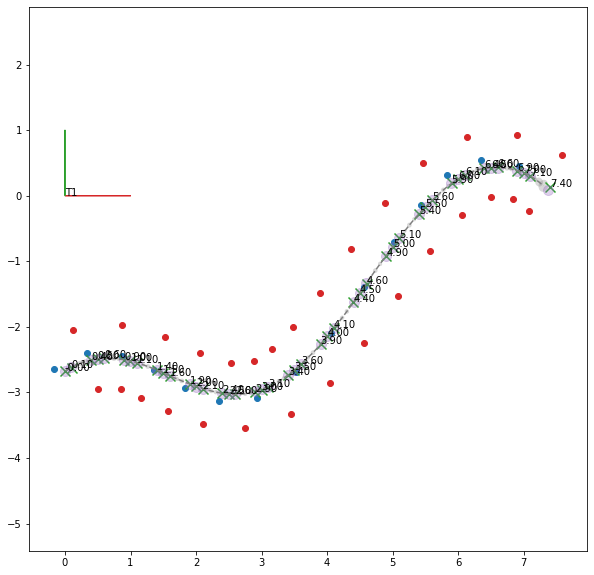

In [2]:
import liblie as ll

def T_q(phi, t):
    T = np.eye(4,4)
    
    T[:3,:3] = ll.expm_so3(ll.wedge_so3(phi))
    T[:3,3] = t
    
    return T
    
def dist(p,q):
    return np.linalg.norm(p-q)

def plot_theodolite(ax, T, c1='tab:red', c2='tab:green', name=""):
    b = T@np.array([0,0,0,1])
    dx = T@np.array([1,0,0,1]) - b
    dy = T@np.array([0,1,0,1]) - b
    
    plt.arrow(*b[:2], *dx[:2], color=c1)
    plt.arrow(*b[:2], *dy[:2], color=c2)
    plt.text(*b[:2],name)
    
def traj(t):
    x = t
    y = t+np.cos(t) - 10*np.exp(.1*(t-10))
    z=0
    theta = np.arctan2(1-np.sin(t)-np.exp(.1*(t-10)), 1)
    
    phi = np.array([0,0,theta])
    
    return phi, x, y, z
    
    
d_truth = 1
#def traj circle
prisms = np.array([[0,0,0,1], [0,d_truth,0,1], T_q(np.array([0,0,np.pi/3.]), np.array([0,0,0]))@np.array([0,d_truth,0,1])])
center = np.mean(prisms, 0)
center[3]=0

for i in range(len(prisms)):
    prisms[i] -= center
    
prisms[1][2] = .5
prisms[2][2] = 1

#def traj circle
freq_th = 2#Hz
t_shift = [0,.1,.4]

N=15
def gen_points(N):
    p1s = np.zeros((4,N))
    p2s = np.zeros((4,N))
    p3s = np.zeros((4,N))
    
    ts = []
    
    poses = []
    for i in range(N):
        ti = float(i)/freq_th
        for j in range(3):
            t = ti + t_shift[j] + (.001*(np.random.rand()-.5)) #small noise so random intervals
            phi, x, y, z = traj(t)
            T = T_q(phi, np.array([x,y,z]))
            if j==0:
                p1s[:,i] = T@prisms[0]
            elif j==1:
                p2s[:,i] = T@prisms[1]
            elif j==2:
                p3s[:,i] = T@prisms[2]
                
            poses += [*phi, x, y, z]
            ts += [t]
    
    ts = np.array(ts)    
    poses=np.array(poses)
    
    return ts, poses, p1s, p2s, p3s

ts, poses, p1s, p2s, p3s = gen_points(N)

plt.figure(figsize=(10,10))
plt.axis('equal')
ax = plt.gca()

plot_theodolite(ax,np.eye(4,4), name="T1")

plt.scatter(p1s[0,:], p1s[1,:], color='tab:red')
plt.scatter(p2s[0,:], p2s[1,:], color='tab:red')
plt.scatter(p3s[0,:], p3s[1,:], color='tab:blue')

xs=[]
ys=[]
for i in range(len(ts)):
    xs += [poses[i*6+3]]
    ys += [poses[i*6+4]]
    plt.text(xs[-1], ys[-1], "{:.2f}".format(ts[i]))

plt.scatter(xs, ys, marker='x', s=100, color='tab:green')

# ---------------------------------------------------------------------------
# def measurements function
# ---------------------------------------------------------------------------

measurements = np.zeros(len(ts)*3) #points in 3D
for i in range(p1s.shape[1]):
    measurements[i*9 + 0 : i*9 + 3] = p1s[:3, i] + .002*np.random.normal(size=3)
    measurements[i*9 + 3 : i*9 + 6] = p2s[:3, i] + .002*np.random.normal(size=3)
    measurements[i*9 + 6 : i*9 + 9] = p3s[:3, i] + .002*np.random.normal(size=3)
    
# Rk = np.eye(3,3)*0.005**2
# R = sc.linalg.block_diag(*[Rk]*len(ts))
R = np.eye(len(ts)*3, len(ts)*3)*0.002**2
    
def g(xi):
    ys = np.zeros(len(ts)*3)
    
    for i in range(len(ts)):
            T = T_q(xi[12*i:12*i+3], xi[12*i+3:12*i+6])
            
            ys[3*i:3*(i+1)] = (T@prisms[i%3])[:3]
    return ys
            
# print(g(np.array([0]*4*3*len(ts))))

def jacobian(f, x, eps=1e-5):
    f_op = f(x)
    J = np.zeros((f_op.shape[0], x.shape[0]))
    
    for j in range(x.shape[0]):
        x_p = np.array(x)
        x_p[j] += eps
        
        J[:,j] = (f(x_p) - f_op) / eps
    return J

def G(xi):
    #approximate derivative
    Bk = []
    for i in range(len(ts)): #=xi.shape[0]/6
        f = lambda xi: (T_q(xi[:3], xi[3:6])@prisms[i%3])[:3]
        Bk += [jacobian(f, xi[12*i: 12*(i+1)])]
    
    return sc.linalg.block_diag(*Bk)

# # #---------------------------------------------------------------------------
# # #def system
# # #---------------------------------------------------------------------------

A = np.block([[np.zeros((6,6)), np.eye(6,6)],
              [np.zeros((6,6)), np.zeros((6,6))]])

def int_exp(dt):
    return dt*np.eye(*A.shape) + dt**2/2.*A
    
us =  np.zeros(len(ts)-1)
#if B = 0, the system does not take into account the command
B = np.zeros((12,1))
# B[2,0] = B[3,1] = 1 #command acceleration
#----------------------------------------------------------

L = np.block([[np.zeros((6,6))],
              [np.eye(6,6)]]) #noise on acceleration
Q = np.eye(6,6)* 1**2
Q[0,0] = Q[1,1] = np.radians(20)**2 #roll and pitch
Q[2,2] = np.radians(20)**2 #yaw
Q[5,5] = .2**2 # z acceleration is lower

#initial position/speed and cov
x0 = np.array([0.]*12)
P0 = np.eye(12,12) * 1000**2

#create noisy guess
x_sol = np.zeros(12*len(ts))

for i in range(len(ts)):
    x_sol[12*i : 12*i+6] = poses[6*i : 6*i+6] + .5*np.random.normal(size=6)

sys_2DWarthog = GPs.LTI_system(A,B,L,Q, int_exp=int_exp)
gp = GPs.GPs_LTI_nL_m(sys_2DWarthog, ts, us, measurements, g, G, R, P0=P0, x0=x0, max_it=10, initial_guess=x_sol, rtol=1e-8)
# GPs = GPs_LTI(sys_2DWarthog, ts, us, measurements, C, R, P0=P0, x0=x0)
post_mean = gp.infer_mean()
post_covs = gp.infer_covariance()
post_mean_r = post_mean.reshape(-1, 12)

xs = post_mean_r[:,3]
ys = post_mean_r[:,4]
plt.scatter(xs, ys, c='tab:purple', marker='o', s=100, label='posterior mean', alpha=.3)

taus = np.linspace(min(ts)+1e-2,max(ts),100, endpoint=False)
xs = []
ys = []
zs = []
phi1 = []
phi2 = []
phi3 = []
covs = []
print("Querying trajectory...")
for tau in tqdm.tqdm(taus):
    m, cov = gp.query_posterior(tau)
    xs += [m[3]]
    ys += [m[4]]
    zs += [m[5]]
    phi1 += [m[0]]
    phi2 += [m[1]]
    phi3 += [m[2]]
    covs += [cov]
    GPs.plot_ellipse(plt.gca(), [xs[-1], ys[-1]], (cov[3:5, 3:5]), color='tab:gray', alpha=.3, zorder=0)

plt.plot(xs, ys, c='tab:gray', ls='--', label='posterior mean interpolated')    

Text(0.5, 1.0, 'Absolute [m]')

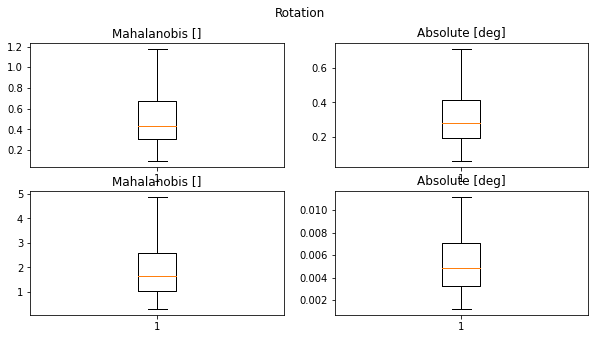

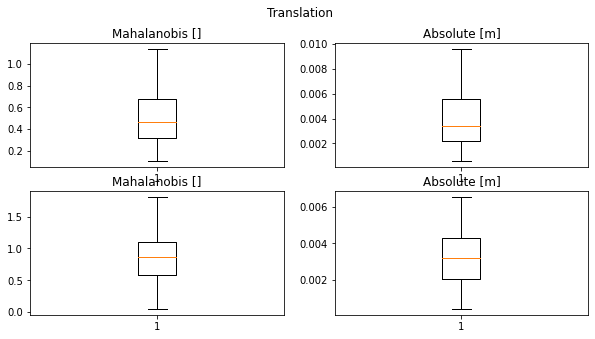

In [4]:


err_m_t = []
err_a_t = []
err_m_r = []
err_a_r = []
for tau,i,cov in zip(taus, range(len(taus)), covs):
    tr= traj(tau)
    gt = np.array([*tr[0], *tr[1:]])
    e_r = np.array(gt[:3] - np.array([phi1[i], phi2[i], phi3[i]]))[np.newaxis].T
    e_t = np.array(gt[3:] - np.array([xs[i], ys[i], zs[i]]))[np.newaxis].T
#     
    err_m_r += [np.sqrt((e_r.T@np.linalg.inv(cov[:3,:3])@e_r)[0,0])]
    err_a_r += [np.sqrt((e_r.T@e_r)[0,0])]
    err_m_t += [np.sqrt((e_t.T@np.linalg.inv(cov[3:6,3:6])@e_t)[0,0])]
    err_a_t += [np.sqrt((e_t.T@e_t)[0,0])]

fig,axs_r = plt.subplots(2,2, figsize=(10,5))
plt.suptitle("Rotation")
axs_r[0,0].boxplot(err_m_r, showfliers=False)
axs_r[0,0].set_title("Mahalanobis []")
axs_r[0,1].boxplot(np.degrees(err_a_r), showfliers=False)
axs_r[0,1].set_title("Absolute [deg]")

fig,axs_t = plt.subplots(2,2, figsize=(10,5))
plt.suptitle("Translation")
axs_t[0,0].boxplot(err_m_t, showfliers=False)
axs_t[0,0].set_title("Mahalanobis []")
axs_t[0,1].boxplot(err_a_t, showfliers=False)
axs_t[0,1].set_title("Absolute [m]")


err_m_t = []
err_a_t = []
err_m_r = []
err_a_r = []
for t, i in zip(ts, range(len(ts))):
    tr= traj(t)
    gt = np.array([*tr[0], *tr[1:]])
    m = post_mean_r[i][:6]
    cov = post_covs[12*i:12*(i+1), 12*i:12*(i+1)]
    
    e_r = np.array(gt[:3] - m[:3])[np.newaxis].T
    e_t = np.array(gt[3:] - m[3:])[np.newaxis].T
#     
    err_m_r += [np.sqrt((e_r.T@np.linalg.inv(cov[3:6,3:6])@e_r)[0,0])]
    err_a_r += [np.sqrt((e_r.T@e_r)[0,0])]
    err_m_t += [np.sqrt((e_t.T@np.linalg.inv(cov[3:6,3:6])@e_t)[0,0])]
    err_a_t += [np.sqrt((e_t.T@e_t)[0,0])]

axs_r[1,0].boxplot(err_m_r, showfliers=False)
axs_r[1,0].set_title("Mahalanobis []")
axs_r[1,1].boxplot(err_a_r, showfliers=False)
axs_r[1,1].set_title("Absolute [deg]")

axs_t[1,0].boxplot(err_m_t, showfliers=False)
axs_t[1,0].set_title("Mahalanobis []")
axs_t[1,1].boxplot(err_a_t, showfliers=False)
axs_t[1,1].set_title("Absolute [m]")
# plt.figure()
# # plt.plot(post_mean_r[:,3],post_mean_r[:,4]) 
# # plt.plot([traj(t)[1] for t in ts], [traj(t)[2] for t in ts]) 

# plt.boxplot([ts[i+1]-ts[i] for i in range(len(ts)-1)], showfliers=False)

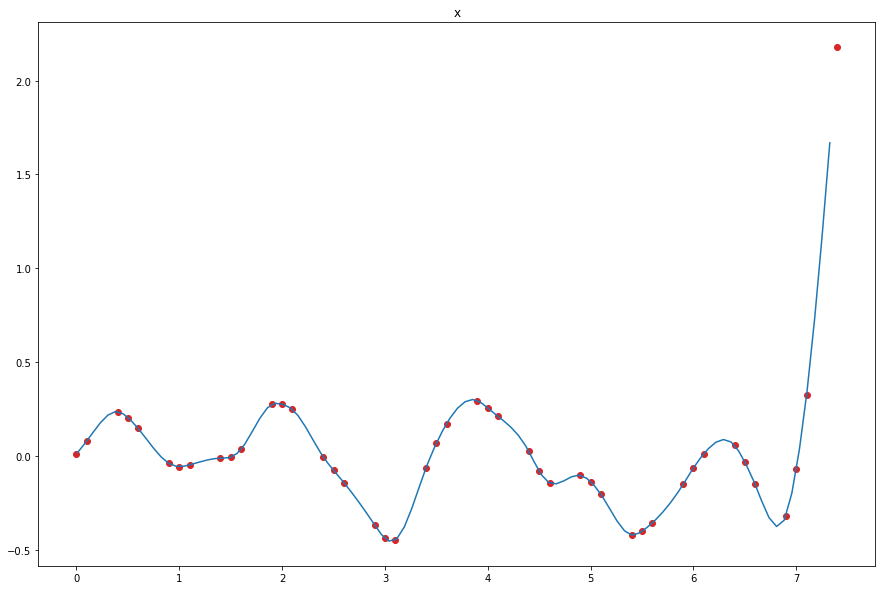

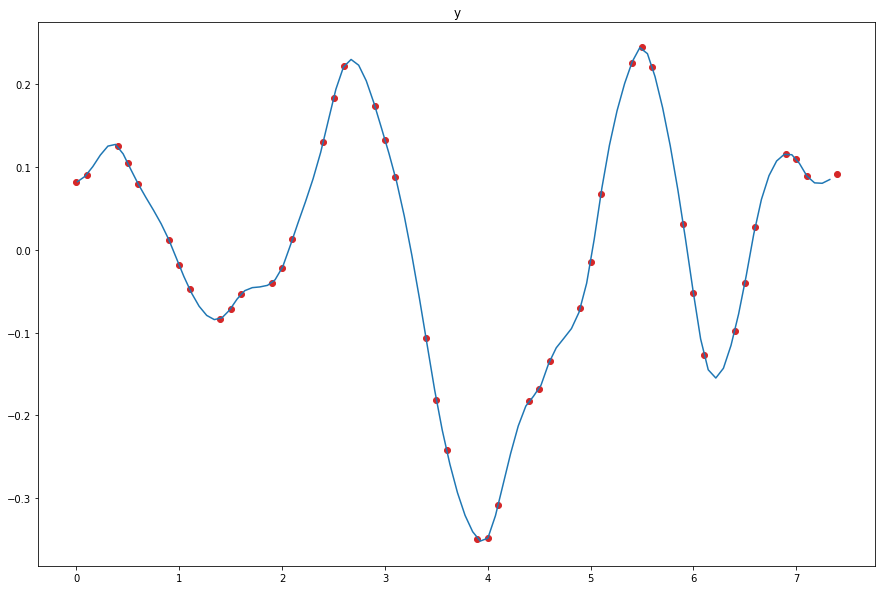

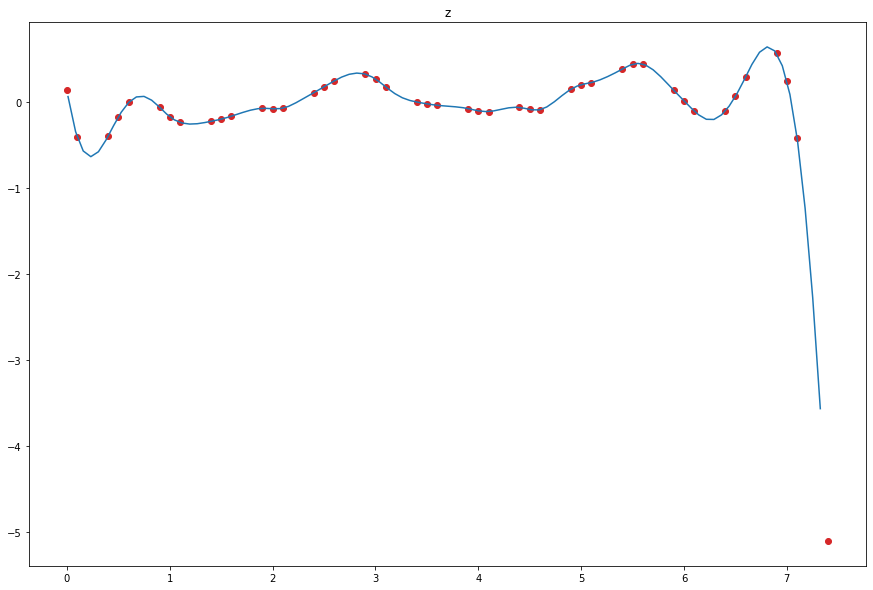

In [137]:
for index,n,c in zip([0,1,2], ['x', 'y', 'z'], [phi1, phi2, phi3]): 

    plt.figure(figsize=(15,10))
    plt.title(n)
    
    plt.plot(taus, np.degrees([c[i] - traj(taus[i])[0][index] for i in range(len(taus))]))
    plt.scatter(ts, np.degrees([post_mean_r[i,index] - traj(ts[i])[0][index] for i in range(len(ts))]), color='tab:red')